# Importing packages

In [ ]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import tqdm

from sklearn.metrics import mean_squared_error

import os
import sys
sys.path.append('..')
sys.path.append('../utils/')
from utils.Feature_Engineering import*

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 20,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 18,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (20, 8),
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.family': 'Times New Roman',
    'legend.fontsize': 13,
    'legend.framealpha': 0.8,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


# Importing dataset


In [ ]:
path_to_dataset = "../1.ETL/Datasets/Processed/ETL2_train_label.parquet"
df = pd.read_parquet(path_to_dataset)

In [ ]:
df1 = df[(df['Process']=='OP06')]

In [ ]:
df1.reset_index(drop=True, inplace=True)

In [ ]:
del df

# Implemented features

- The features developed here are categorized into three types: statistical (time-domain), energy, and frequency domain features. Each feature is calculated using a rolling window approach.

### 1. Time domain

#### 1.1 Statistical features

- Mean
- Standard Deviation
- Maximun
- Minimun
- Median
- Skewness: measures the asymmetry of the data distribution, relative to the normal distribution. <br>
- Kurtosis: measures the tailedness of the data distribution. High kurtosis can suggest the existence of high intensity events, which may indicate equipament failures. <br>
- RMS: represents the square root of the average of the squares of the values, indicating the magnitude of a varying signal. Changes in the RMS levels can indicate machanical faults in the equipament.<br>

#### 1.2 Non-dimensional features

- Shape Factor: RMS divided by mean and crest factor 
- Crest Factor: the ratio of the peak amplitude to the RMS value, indicating the sharpness of peaks. High crest factors can be used to detect sudden spikes in the signal which may signify issues or sensor faults. <br>
- Impulse Factor: the ratio of the peak amplitude to the average absolute amplitude. This feature can helps identify spikes, which might signify mechanical impacts or other anomalies (Caesarendra e Tjahjowidodo, 2017).<br>
- Margin Factor: the ratio of the peak amplitude to the square of the mean of the square root of the absolute amplitudes. A high margin factor value may be indicative of sporadic high energy events or impacts within the system being monitored (Caesarendra e Tjahjowidodo, 2012)

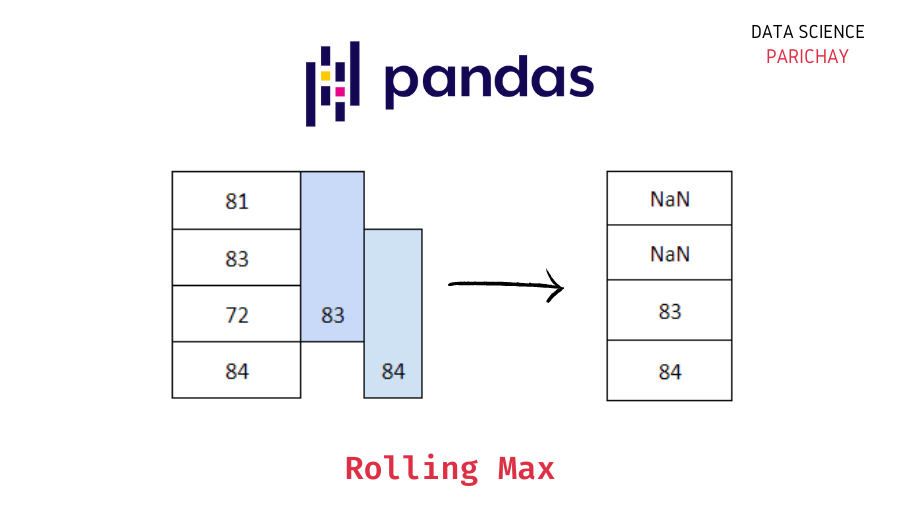

In [ ]:
processed_df_statistical = process_time_series(df1, feature_type='statistical', window_size=500)

In [ ]:
processed_df_statistical

### 2. Energy features

- Energy: total energy within each rolling window. In this context energy is defined as the sum of the squares of the signal amplitudes, which represents the power or intensity of the signal over time. Sedden changes in energy leves can indicate in operation conditions or faults in the system. <br>
- Energy entropy: measures the randomness or unprectability of the energy distribution within the window. A decrease in entropy could indicate a more predictable and regular signal, while an increase may suggest increasing complexity or disorder, possibly due to system degradation or external disturbances. <br>
- Normalized energy: same as energy but normilized to facilitate comparison.

In [ ]:
processed_df_energy = process_time_series(df1, feature_type='energy', window_size=500)

In [ ]:
processed_df_energy

### 3. Frequency features

- Spectral Mean: Average of the power spectrum, indicating the central tendency of signal power distribution across frequencies.
- Spectral Standard Deviation: Measure of dispersion or spread in the power spectrum, showing how widely signal power is distributed across different frequencies.
- Spectral Kurtosis: Quantifies the "peakedness" or presence of outliers in the power spectrum, highlighting sudden shifts or anomalies in frequency patterns.

In [ ]:
#processed_df_frequency = process_time_series(df1, feature_type='frequency', window_size=500)

- Due to the extended calculation time, I'm currently not using this approach in the analysis.

In [ ]:
#processed_df_frequency

### 4. Jerk calculation

Jerk is the rate of change of acceleration over time (the derivative of acceleration). It measures how quickly acceleration changes.
- High jerk values could indicate abrupt changes in acceleration, which often signal sudden mechanical faults, impact events, or rapid system instability. So maybe it could help to identify abnormal patterns that might not be evident in acceleration alone - haven't seen this feature being applied to anomaly detection yet, its only a try :) 

In [ ]:
processed_df_jerk = process_time_series(df1, feature_type='jerk')

In [ ]:
processed_df_jerk

### 5.Wavelet packet transform (WPT)

- WPT is a wavelet decomposition technique that divides a signal into frequency sub-bands using a hierarchical, tree-like structure (as shown below). This approach provides an extensive analysis of both high and low-frequency components. It can detect irregular patterns across different frequency bands, capturing localized anomalies or transient signals that conventional methods might miss. 
- Hussain et al. (2024) explored the use of WPT for monitoring the health of CNC machining processes using the same data and found that the coif8 and db14 mother wavelets at decomposition level 3 (L3) offer the best classification performance. Consequently, this study adopts the db14 wavelet for analysis.

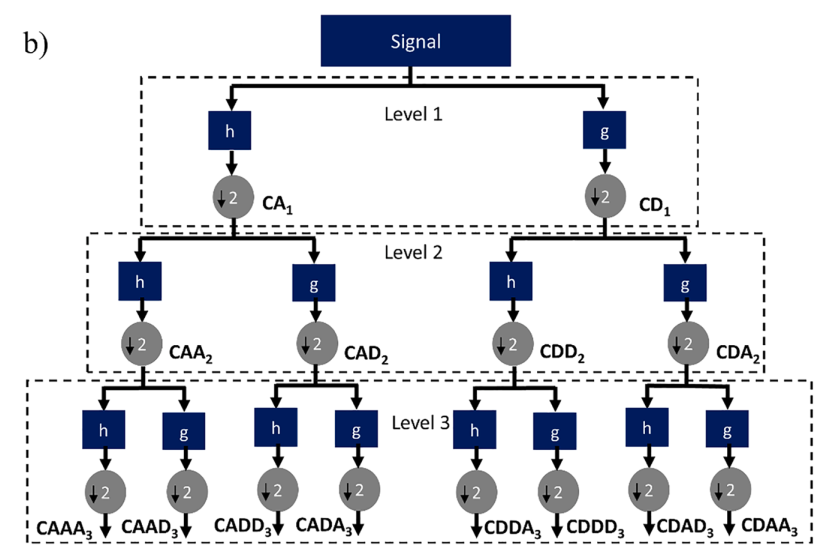

In [ ]:
processed_df_DWT = process_time_series(df1, feature_type='wavelet')

In [ ]:
processed_df_DWT

### 6. Approximate entropy (ApEn) 

- It is a measure that quantifies the regularity of signals. A low ApEn value indicates more regular and predictable signal behavior. The calculation of ApEn involves comparing reconstructed vectors of the signal and evaluating the predictability of patterns within it. 
- Caesarendra and Tjahjowidodo (2017) used this measure based on a study indicating that the deterioration of bearing condition leads to an increase in the number of frequency components, which results in reduced regularity and, consequently, an increase in ApEn values.

In [ ]:
#processed_df_ApEn = process_time_series(df1, feature_type='ApEn', window_size=500, m=100, r = 0.2)

- Due to the extended calculation time, I'm currently not using this approach in the analysis.

###  Concat in one dataframe

In [ ]:
df_features = pd.concat([processed_df_statistical,processed_df_energy,processed_df_DWT,processed_df_jerk], axis=1)

In [ ]:
df_features

In [ ]:
#sns.heatmap(df_features.isnull(), cmap='viridis', cbar=False, yticklabels=False)

In [ ]:
df_features.dropna(inplace=True)

In [ ]:
df_features = df_features.loc[:, ~df_features.columns.duplicated()]

In [ ]:
columns_to_rename = {'X_X_axis': 'X_axis', 'Y_Y_axis': 'Y_axis', 'Z_Z_axis': 'Z_axis'}
df_features.rename(columns=columns_to_rename, inplace=True)

In [ ]:
df_features

In [ ]:
path_to_save_parquet = 'Datasets/OP6_Features.parquet'
df_features.to_parquet(path_to_save_parquet)